In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lenta_40k.csv.zip')

In [ ]:
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):

        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)

        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить

        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [ ]:
MAX_LEN = 200

In [ ]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [ ]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [ ]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=128, shuffle=True, )

In [ ]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=True)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

from tqdm.notebook import tqdm
import numpy as np

def train(model, iterator, optimizer, criterion):
    model.train()

    epoch_loss = []
    epoch_ac = []
    epoch_rec = []
    epoch_prec = []

    pbar = tqdm(iterator, desc="Training", leave=False)

    for texts, ys in pbar:
        optimizer.zero_grad()

        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))

        loss.backward()
        optimizer.step()

        preds = predictions.detach().cpu().numpy().argmax(1)
        y_true = ys.numpy()

        epoch_loss.append(loss.item())
        epoch_ac.append(accuracy_score(y_true, preds))
        epoch_rec.append(recall_score(y_true, preds, average='macro', zero_division=0))
        epoch_prec.append(precision_score(y_true, preds, average='macro', zero_division=0))

        # Update tqdm bar
        pbar.set_postfix(
            loss=np.mean(epoch_loss),
            accuracy=np.mean(epoch_ac),
            recall=np.mean(epoch_rec),
            precision=np.mean(epoch_prec)
        )

    return (np.mean(epoch_ac), np.mean(epoch_rec), np.mean(epoch_prec))


def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = []
    epoch_ac = []
    epoch_rec = []
    epoch_prec = []

    with torch.no_grad():
        for texts, ys in tqdm(iterator, desc="Evaluating", leave=False):
            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))

            preds = predictions.detach().cpu().numpy().argmax(1)
            y_true = ys.numpy()

            epoch_loss.append(loss.item())
            epoch_ac.append(accuracy_score(y_true, preds))
            epoch_rec.append(recall_score(y_true, preds, average='macro', zero_division=0))
            epoch_prec.append(precision_score(y_true, preds, average='macro', zero_division=0))

    return (np.mean(epoch_ac), np.mean(epoch_rec), np.mean(epoch_prec))

In [ ]:
class Conv_layer_with_pad(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.KERNEL_SIZE = 7
        self.IN_CHANNELS = in_channels
        self.OUT_CHANNELS = out_channels
        self.STRIDE = 1
        self.conv = nn.Conv1d(self.IN_CHANNELS,
                              self.OUT_CHANNELS,
                              kernel_size=self.KERNEL_SIZE,
                              stride=self.STRIDE, )

        self.act = nn.LeakyReLU()

    def forward(self, embedded):
        """
        Раньше мы расчитывали длину, которая получится, после применения сверточного слоя  по формуле:
        OUTPUT_LENGTH = (((MAX_LEN-(KERNEL_SIZE-1)-1)/STRIDE)+1)


        Теперь мы хотим на выходе получить длину, которая будет соответствовать длине изначальной последовательности.
        Т.е. мы знаем OUTPUT_LENGTH и наша задача найти такой MAX_LEN, при котором он получается (остальные параметры фиксированы)
        Перенесем все известные значения влево и получится вот такая формула
        ((OUTPUT_LENGTH-1)*STRIDE)+1+(KERNEL_SIZE-1) = MAX_LEN

        Используя нужное значение MAX_LEN, нам нужно допаддить изначальную последовательность до этой длины
        Т.к. мы будет падить с двух сторон, то нужно, чтобы получившееся число делилось на 2



        """
        MAX_LEN = embedded.size(2)
        EXP_LEN = ((MAX_LEN-1)*self.STRIDE)+1+(self.KERNEL_SIZE-1)

        # нужно чтобы все сходилось, иначе выдавать ошибку
        assert not (EXP_LEN-MAX_LEN)%2, f"Не ровный паддинг! {EXP_LEN}"

        # допустим чтобы получить изначальную длину в 200
        # нужно добавить нулей до 210
        # тогда мы добавляем 5 нулей слева и 5 справа
        # ассерт выше выкинул бы ошибку если бы у нас получалось например 209,
        # то есть мы не смогли бы ровно западить с 2 сторон
        padded = F.pad(embedded, (int((EXP_LEN-MAX_LEN)/2),
                                                   int((EXP_LEN-MAX_LEN)/2)))

        convoluted = self.conv(padded)

        return self.act(convoluted)



class Clf(nn.Module):

    def __init__(self, output_dim):

        super().__init__()
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 128
        self.MAX_LEN = 200

        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)

        self.dropout1 = nn.Dropout(0.15)
        self.conv1 = Conv_layer_with_pad(self.EMB_DIM, 64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout(0.3)
        self.conv2 = Conv_layer_with_pad(64, 128)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.dropout3 = nn.Dropout(0.25)
        self.conv3 = Conv_layer_with_pad(128, 256)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.dropout4 = nn.Dropout(0.2)
        self.conv4 = Conv_layer_with_pad(256, 128)
        self.pool4 = nn.AdaptiveMaxPool1d(output_size=50)

        self.parallel_conv1 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.parallel_pool1 = nn.AdaptiveAvgPool1d(output_size=25)
        self.parallel_dropout1 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(1600, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.output_act = nn.LogSoftmax(dim=1)


    def forward(self, text):

        embedded = self.embedding(text)  # [batch_size, seq_len, emb_dim]
        x = embedded.permute(0, 2, 1)  # [batch_size, emb_dim, seq_len]

        x = self.dropout1(x)
        x = self.conv1(x)  # [batch_size, 64, 200]
        x = self.pool1(x)  # [batch_size, 64, 100]

        x = self.dropout2(x)
        x = self.conv2(x)  # [batch_size, 128, 100]
        x = self.pool2(x)  # [batch_size, 128, 50]

        x = self.dropout3(x)
        x = self.conv3(x)  # [batch_size, 256, 50]
        x = self.pool3(x)  # [batch_size, 256, 25]

        x = self.dropout4(x)
        x = self.conv4(x)  # [batch_size, 128, 25]
        x = self.pool4(x)  # [batch_size, 128, 50]

        x = self.parallel_conv1(x)
        x = self.parallel_pool1(x)
        x = self.parallel_dropout1(x)

        flat = torch.flatten(x, 1)  # [batch_size, 64*25]

        x = self.fc1(flat)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)
        output = self.output_act(x)

        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
acs = []
acs_eval = []

recs = []
recs_eval = []

precs = []
precs_eval = []

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")

    train_ac, train_rec, train_prec = train(model, training_generator, optimizer, criterion)
    val_ac, val_rec, val_prec = evaluate(model, valid_generator, criterion)

    print(f"Train Accuracy: {train_ac:.4f} | Val Accuracy: {val_ac:.4f}")
    print(f"Train Recall: {train_rec:.4f} | Val Recall: {val_rec:.4f}")
    print(f"Train Precision: {train_prec:.4f} | Val Precision: {val_prec:.4f}")

    acs.append(train_ac)
    acs_eval.append(val_ac)
    recs.append(train_rec)
    recs_eval.append(val_rec)
    precs.append(train_prec)
    precs_eval.append(val_prec)



Epoch 1/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.2597 | Val Accuracy: 0.3540
Train Recall: 0.1177 | Val Recall: 0.1994
Train Precision: 0.0619 | Val Precision: 0.1236

Epoch 2/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.4152 | Val Accuracy: 0.4948
Train Recall: 0.2518 | Val Recall: 0.3248
Train Precision: 0.2156 | Val Precision: 0.2832

Epoch 3/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.5584 | Val Accuracy: 0.6000
Train Recall: 0.3644 | Val Recall: 0.4008
Train Precision: 0.3372 | Val Precision: 0.3882

Epoch 4/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.6287 | Val Accuracy: 0.6294
Train Recall: 0.4299 | Val Recall: 0.4336
Train Precision: 0.4205 | Val Precision: 0.4080

Epoch 5/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.6675 | Val Accuracy: 0.6567
Train Recall: 0.4739 | Val Recall: 0.4721
Train Precision: 0.4653 | Val Precision: 0.4483

Epoch 6/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.7044 | Val Accuracy: 0.6798
Train Recall: 0.5199 | Val Recall: 0.4914
Train Precision: 0.5101 | Val Precision: 0.4849

Epoch 7/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.7350 | Val Accuracy: 0.6868
Train Recall: 0.5588 | Val Recall: 0.4996
Train Precision: 0.5509 | Val Precision: 0.5004

Epoch 8/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.7585 | Val Accuracy: 0.6960
Train Recall: 0.5851 | Val Recall: 0.5183
Train Precision: 0.5807 | Val Precision: 0.5191

Epoch 9/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.7797 | Val Accuracy: 0.7120
Train Recall: 0.6174 | Val Recall: 0.5458
Train Precision: 0.6166 | Val Precision: 0.5449

Epoch 10/10


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Train Accuracy: 0.7950 | Val Accuracy: 0.6868
Train Recall: 0.6380 | Val Recall: 0.5589
Train Precision: 0.6399 | Val Precision: 0.5445


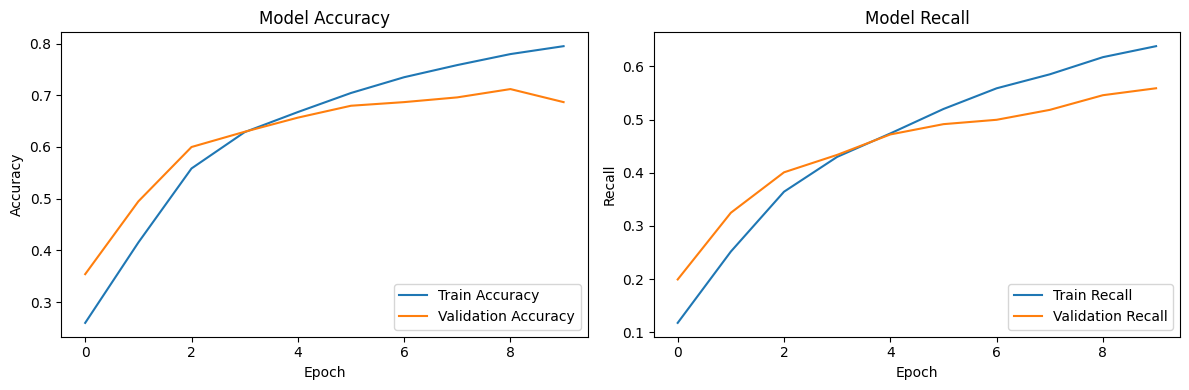

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acs, label='Train Accuracy')
plt.plot(acs_eval, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recs, label='Train Recall')
plt.plot(recs_eval, label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
print("\nДоступные темы:")
for i, topic in id2label.items():
    print(f"{i}: {topic}")


Доступные темы:
0: Спорт
1: Бизнес
2: Силовые структуры
3: Крым
4: Ценности
5: Легпром
6: 69-я параллель
7: Культура
8: Культпросвет 
9: Библиотека
10: Дом
11: Путешествия
12: Мир
13: Наука и техника
14: Из жизни
15: Россия
16: Экономика
17: Бывший СССР
18: Интернет и СМИ


In [ ]:
def predict_text_class(text, model, word2id, label2id, id2label, device, max_len=200):
    model.eval()

    tokens = preprocess(text)
    token_ids = [word2id.get(token, word2id['PAD']) for token in tokens[:max_len]]

    if len(token_ids) < max_len:
        token_ids.extend([word2id['PAD']] * (max_len - len(token_ids)))
    else:
        token_ids = token_ids[:max_len]

    input_tensor = torch.LongTensor([token_ids]).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.exp(logits)
        predicted_class_id = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class_id].item()

    predicted_label = id2label[predicted_class_id]

    return predicted_label, confidence

sample_text_1 = "Президент России Владимир Путин провел встречу с иностранным лидером. В ходе переговоров стороны обсудили вопросы международного сотрудничества и экономического развития."
sample_text_2 = "Ханси Флик пообещал, что команда прибавит – и теперь у «Барсы» 9 побед в 9 матчах и ни одного пропущенного за 520 последних минут."
predicted_topic_1, confidence_1 = predict_text_class(sample_text_1, model, word2id, label2id, id2label, device)
predicted_topic_2, confidence_2 = predict_text_class(sample_text_2, model, word2id, label2id, id2label, device)

print(f"Текст: {sample_text_1}")
print(f"Предсказанный класс: {predicted_topic_1}")
print(f"Уверенность модели: {confidence_1:.4f}")

print(f"Текст: {sample_text_2}")
print(f"Предсказанный класс: {predicted_topic_2}")
print(f"Уверенность модели: {confidence_2:.4f}")

Текст: Президент России Владимир Путин провел встречу с иностранным лидером. В ходе переговоров стороны обсудили вопросы международного сотрудничества и экономического развития.
Предсказанный класс: Россия
Уверенность модели: 0.7403
Текст: Ханси Флик пообещал, что команда прибавит – и теперь у «Барсы» 9 побед в 9 матчах и ни одного пропущенного за 520 последних минут.
Предсказанный класс: Спорт
Уверенность модели: 0.8736
